# Workflow: 
## 1) Geological model generation/definition
## 2) Training data generation for GAN
## 3) Data preprocessing
## 4) VAE: training
## 5) Use encoder from VAE model to generate images

In [1]:
import numpy as np


from numpy import expand_dims
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

import random
from random import randint
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import keras
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.utils.vis_utils import plot_model
from keras.datasets.mnist import load_data
from keras.layers import BatchNormalization
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras import layers
from keras.datasets import mnist
from keras import backend as K

## 1. Model generation: Import training image

In [2]:
data = np.loadtxt('ti1.txt',skiprows=3)

In [3]:
data=np.reshape(data, (470, 470))
data.shape

(470, 470)

In [4]:
def plot_im1(img):
    plt.figure(figsize=(20, 4))
    plt.imshow(img,interpolation='none')
    plt.jet()
    plt.title('TI '+str(img.shape))

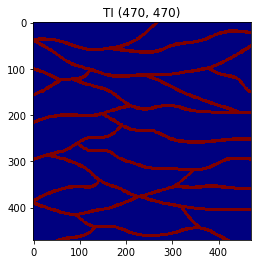

In [5]:
plot_im1(data)

# 2.Training data generation:
## 10 000 samples 64x64

In [6]:
# Crop randomly the image
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[64, 64])
  cropped_image=cropped_image.numpy()
  return cropped_image

In [7]:
# Generate 10 000 64x64 realizations for training data
train_size=10000
training_data=[None] * train_size
for i in range(train_size):
    training_data[i]=random_crop(data)

In [8]:
# Generate 1000 64x64 realizations for test data
test_size=1000
test_data=[None] * test_size
for i in range(test_size):
    test_data[i]=random_crop(data)

(64, 64)


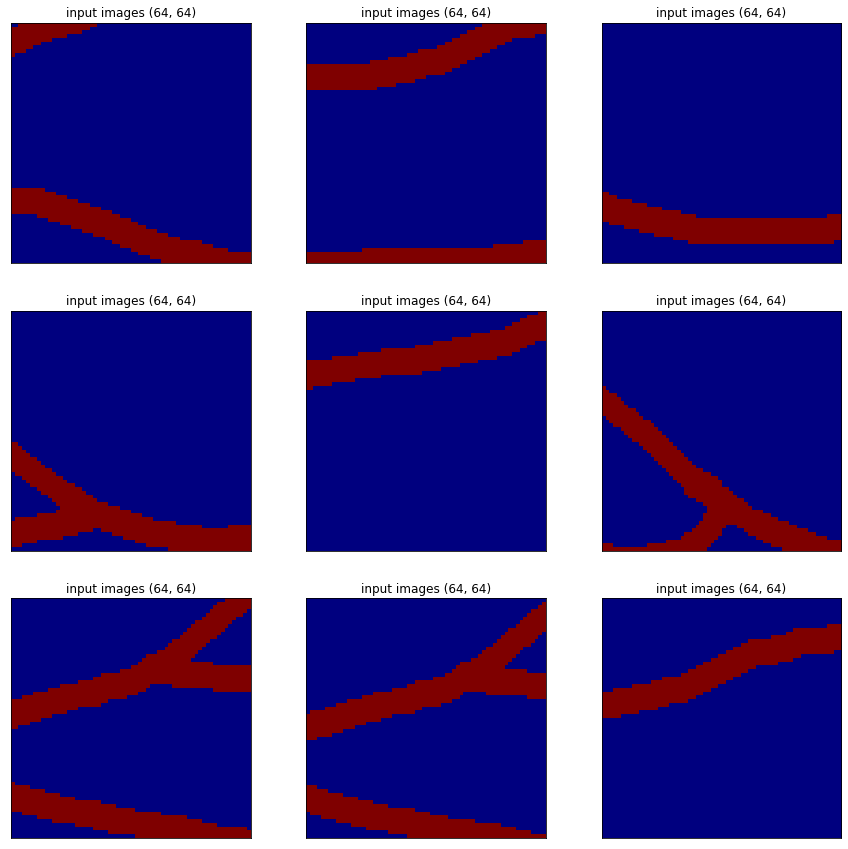

In [9]:
# plot some subset of images for training data
print(training_data[1].shape)
#plot_im(training_data[3])
n = 10
plt.figure(figsize=(15, 15))
for i in range(9):
    # Display original
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(test_x[i].reshape(28, 28))
    #plt.imshow(original[i])
    plt.imshow(training_data[i],interpolation='none')
    plt.jet()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('input images '+str(training_data[1].shape))

(64, 64)


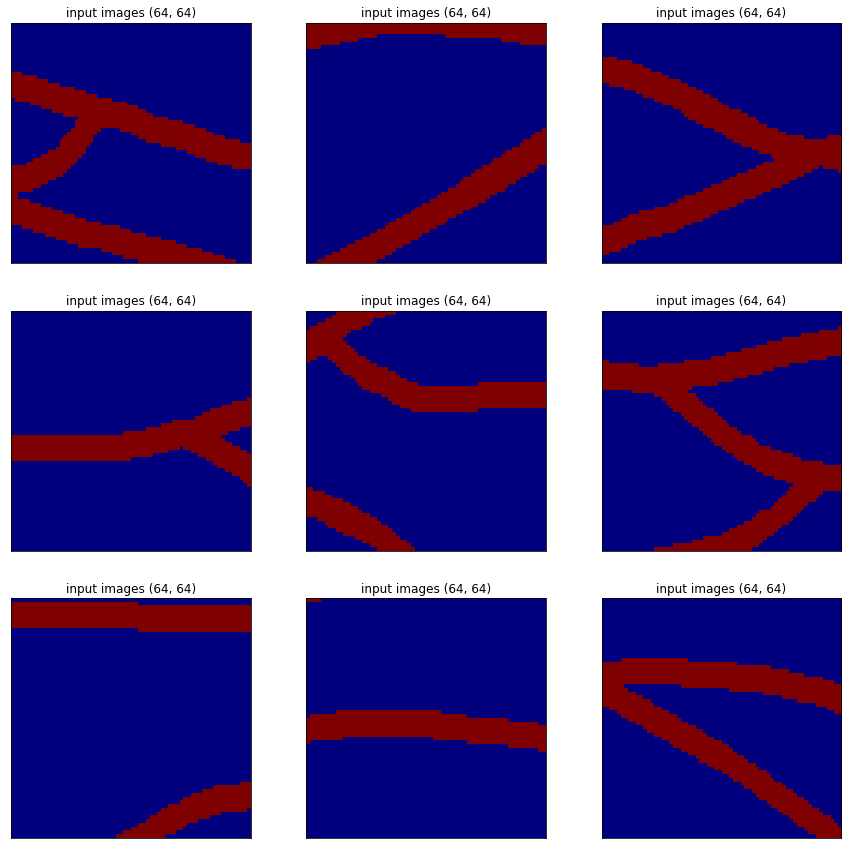

In [10]:
# plot some subset of images for test data
print(test_data[1].shape)
#plot_im(training_data[3])
n = 10
plt.figure(figsize=(15, 15))
for i in range(9):
    # Display original
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(test_x[i].reshape(28, 28))
    #plt.imshow(original[i])
    plt.imshow(test_data[i],interpolation='none')
    plt.jet()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('input images '+str(test_data[1].shape))

# 3. Data preprocessing

In [11]:
print(len(training_data)) #1200
print(training_data[1].shape)

10000
(64, 64)


In [12]:
print(len(test_data)) #1200
print(test_data[1].shape)

1000
(64, 64)


In [13]:
training_data_np = np.dstack(training_data)
print(training_data_np.shape)
training_data_np = np.rollaxis(training_data_np,-1)
print(training_data_np.shape)

(64, 64, 10000)
(10000, 64, 64)


In [14]:
test_data_np = np.dstack(test_data)
print(test_data_np.shape)
test_data_np = np.rollaxis(test_data_np,-1)
print(test_data_np.shape)

(64, 64, 1000)
(1000, 64, 64)


In [15]:
training_data_fc=np.reshape(training_data_np,(len(training_data_np),training_data_np.shape[1]*training_data_np.shape[1]))
test_data_fc=np.reshape(test_data_np,(len(test_data_np),test_data_np.shape[1]*test_data_np.shape[1]))
print(training_data_fc.shape)
print(test_data_fc.shape)

(10000, 4096)
(1000, 4096)


In [16]:
training_data_cnn=np.reshape(training_data_np,(len(training_data_np),64,64,1))
test_data_cnn=np.reshape(test_data_np,(len(test_data_np),64,64,1))
print(training_data_cnn.shape)
print(test_data_cnn.shape)

(10000, 64, 64, 1)
(1000, 64, 64, 1)


# 4. VAE training

In [17]:
inputs = keras.Input(shape=(4096,))
latent_dim = 500

In [18]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon  


In [19]:
def encoder1():
    inputs = keras.Input(shape=(4096,))
    x = layers.Reshape((64, 64, 1))(inputs)
    x = layers.Conv2D(16, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                      padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = layers.Conv2D(16, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), 
                      padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(1, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.3), 
                      padding='same')(x)
    x=layers.Flatten()(x)
    x=layers.Dropout(0.4)(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_sigma = layers.Dense(latent_dim)(x)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])
    model = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
    return z_mean, z_log_sigma, model

In [20]:
encoder1()[2]
encoder=encoder1()[2]
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 64, 64, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 16)   80          reshape_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 16)   64          conv2d_3[0][0]                   
____________________________________________________________________________________________

In [21]:
def decoder1():
    latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Reshape((25, 20, 1))(latent_inputs)
    
    
    x = layers.Conv2D(8, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.3),
                      padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(8, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.3), 
                      padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x=layers.Flatten()(x)
    #x=layers.Dropout(0.4)(x)
    outputs= layers.Dense(4096,activation='sigmoid')(x)
    #x = layers.Reshape((64, 64, 1))(x)
    #outputs = layers.Conv2D(1, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.3),
     #                 padding='same')(x)
    model = keras.Model(latent_inputs, outputs)
    return outputs, model

In [22]:
decoder1()[1]
decoder=decoder1()[1]
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 500)]             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 25, 20, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 20, 8)         40        
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 20, 8)         32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 10, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 10, 8)         264       
_________________________________________________________________
batch_normalization_7 (Batch (None, 12, 10, 8)         32  

In [23]:
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= 4096
kl_loss = 1 + encoder(inputs)[1] - K.square(encoder(inputs)[0]) - K.exp(encoder(inputs)[1])
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [24]:
vae.fit(training_data_fc, training_data_fc,
        epochs=100,
        batch_size=256,
        validation_data=(test_data_fc, test_data_fc))

Epoch 1/100
40/40 [==============================] - 20s 73ms/step - loss: 2194.4222 - val_loss: 2539.0903
Epoch 2/100
40/40 [==============================] - 1s 37ms/step - loss: 1243.7251 - val_loss: 2216.7507
Epoch 3/100
40/40 [==============================] - 1s 37ms/step - loss: 915.7157 - val_loss: 1946.9635
Epoch 4/100
40/40 [==============================] - 1s 37ms/step - loss: 737.2450 - val_loss: 1570.3999
Epoch 5/100
40/40 [==============================] - 1s 37ms/step - loss: 623.6507 - val_loss: 1072.9874
Epoch 6/100
40/40 [==============================] - 1s 37ms/step - loss: 552.6830 - val_loss: 814.6751
Epoch 7/100
40/40 [==============================] - 1s 37ms/step - loss: 498.7830 - val_loss: 782.6210
Epoch 8/100
40/40 [==============================] - 1s 37ms/step - loss: 458.7413 - val_loss: 703.0894
Epoch 9/100
40/40 [==============================] - 1s 37ms/step - loss: 426.5151 - val_loss: 525.0977
Epoch 10/100
40/40 [==============================] - 1s

40/40 [==============================] - 1s 37ms/step - loss: 188.9731 - val_loss: 195.2126
Epoch 80/100
40/40 [==============================] - 2s 38ms/step - loss: 196.7930 - val_loss: 181.7553
Epoch 81/100
40/40 [==============================] - 1s 37ms/step - loss: 187.3695 - val_loss: 174.7376
Epoch 82/100
40/40 [==============================] - 1s 37ms/step - loss: 186.4836 - val_loss: 173.8844
Epoch 83/100
40/40 [==============================] - 1s 37ms/step - loss: 186.5166 - val_loss: 173.7302
Epoch 84/100
40/40 [==============================] - 1s 37ms/step - loss: 186.6989 - val_loss: 180.2606
Epoch 85/100
40/40 [==============================] - 1s 37ms/step - loss: 188.6057 - val_loss: 183.2302
Epoch 86/100
40/40 [==============================] - 1s 37ms/step - loss: 186.3421 - val_loss: 234.7361
Epoch 87/100
40/40 [==============================] - 1s 37ms/step - loss: 213.0892 - val_loss: 177.7751
Epoch 88/100
40/40 [==============================] - 1s 37ms/step -

## 5. Use encoder from VAE model to generate images

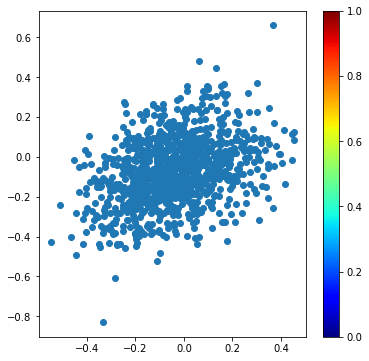

In [25]:
x_test_encoded = encoder.predict(test_data_fc)
x_test_encoded[0].shape
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2][:, 0], x_test_encoded[2][:, 1])
plt.colorbar()
plt.show()

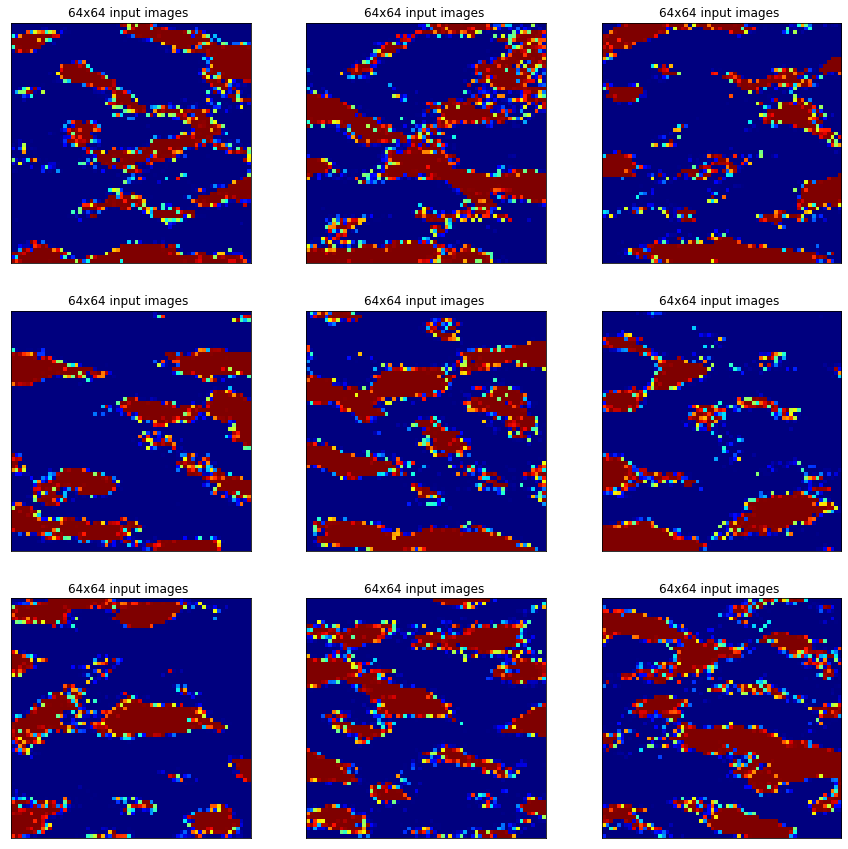

In [26]:
plt.figure(figsize=(15, 15))
for i in range(9):
    
    z_sample = np.random.normal(0,2, 500)
    z_sample=np.expand_dims(z_sample, axis=0)
    x_decoded = decoder.predict(z_sample)
    # Display original
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(test_x[i].reshape(28, 28))
    #plt.imshow(original[i])
    plt.imshow(np.reshape(x_decoded,(64,64)),interpolation='none')
    plt.jet()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('64x64 input images ')
    